This jupyter notebook gives a simple example of how to use Etec to find a lower bound for the topological entropy of a flow.

In [1]:
import Etec2Da as Et
import numpy as np
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint 
import random
from scipy.optimize import curve_fit

We will generate trajectory data from the double gyre ODE.  Data from file could be used instead

In [2]:
# Double Gyre global parameters 
ep = 0.1 #value for epsilon
A = 0.1 #value for A 
om = math.pi/5 #value for omega
params = [ep,A,om]  # repackaging parameters to pass into the various functions

In [3]:
#Computational Parameters
#T_tot = 1
T_i = 2.5  #Starting time
T_f = 42.5

x_l = 0   #Rectangular Domain, x-range left
x_r = 2   #Rectangular Domain, x-range right
y_b = 0   #Rectangular Domain, y-range bottom
y_t = 1   #Rectangular Domain, y-range top

T_num = 1000 #The number of time-steps to take (will use equal time-step evolution for advected particles)
dt = (T_f-T_i)/T_num   #The time-step to use
times =  np.arange(T_i, T_f, dt)  #the set of times used in the ode solver

In [4]:
#The velocity vector function for the Double Gyre
def VelFunc(z,t,p):
    x,y = z
    ep,A,om = p
    a = ep*math.sin(om*t)
    b = 1-2*(ep*math.sin(om*t))
    f = (a*(x**2))+ (b*x)  #f = (a*(x^2))+ (b*x)
    fpri = (2*a*x)+b
    u = -math.pi*A*math.sin(math.pi*f)*math.cos(math.pi*y)
    v = math.pi*A*math.cos(math.pi*f)*math.sin(math.pi*y)*fpri
    return [u,v]

In [5]:
#Now we generate the set of initial conditions (Nnum is deliberately small for a quick run)
de = 0.01  #Small factor to get points off of the edge
IC = []

#Randomly chosen (uniform distribution) points
Nnum = 300  #the number of points
for i in range(Nnum):
    IC.append([np.random.uniform(x_l+de,x_r-de),np.random.uniform(y_b+de,y_t-de)])

In [6]:
#Now we run each inital condition through the ode solver
Traj = []
for i in range(0,len(IC)):
    Traj.append(odeint(VelFunc, IC[i], times, args=(params,)))

In [7]:
#This converts the ode output data structure (Traj[particles][time][x/y]) 
#to the input for E-tec (NTraj[time][particles][x/y])
NTraj = []
for j in range(0,len(Traj[0])):  #iterates first over the times
    NTraj.append([[Traj[i][j][0],Traj[i][j][1]] for i in range(0,len(Traj))])

In [8]:
#this initializes the triangulation2D object.  
tstart = 0  #initial index
tsize = len(NTraj)
tri = Et.triangulation2D(NTraj[tstart])  #this is initialized by passing in the first time-slice
#Since no bands have been specified/passed in, Etec will run in the "mesh" mode, where every initial edge has weight 1

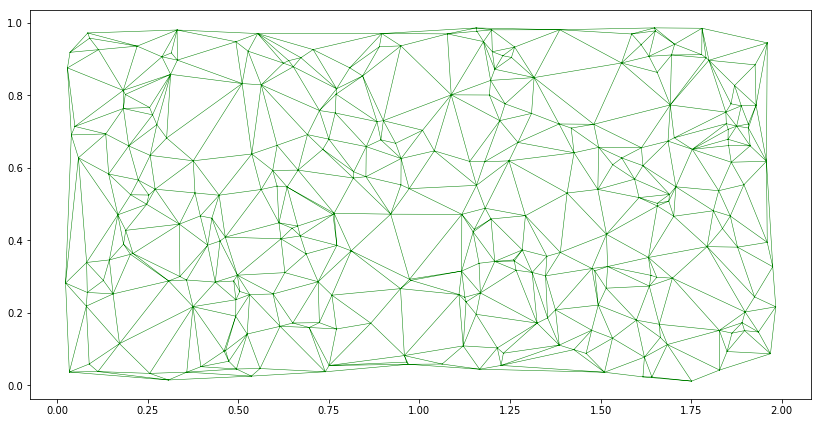

In [9]:
#Let's take a quick look at the initial triangulation
tri.TriangulationPlot()

In [10]:
#Now let's evolve the triangulation forward with E-tec, and record the total weight after each time-step
skipprint = 50 #determines how often to print a status statement
Weights = []
Weights.append(tri.GetWeightTotal())
for i in range(tstart+1,tsize):
    if i%skipprint == 0:
        print("Evolution timestep at: ",i, ", with current total weight = ", tri.GetWeightTotal())
    tri.Evolve(NTraj[i])  #the bulk of E-tec happens here
    Weights.append(tri.GetWeightTotal())

Evolution timestep at:  50 , with current total weight =  883.0
Evolution timestep at:  100 , with current total weight =  1050.0
Evolution timestep at:  150 , with current total weight =  1291.0
Evolution timestep at:  200 , with current total weight =  1700.0
Evolution timestep at:  250 , with current total weight =  2179.0
Evolution timestep at:  300 , with current total weight =  2564.0
Evolution timestep at:  350 , with current total weight =  3210.0
Evolution timestep at:  400 , with current total weight =  3813.0
Evolution timestep at:  450 , with current total weight =  4525.0
Evolution timestep at:  500 , with current total weight =  5832.0
Evolution timestep at:  550 , with current total weight =  7509.0
Evolution timestep at:  600 , with current total weight =  9081.0
Evolution timestep at:  650 , with current total weight =  12330.0
Evolution timestep at:  700 , with current total weight =  15029.0
Evolution timestep at:  750 , with current total weight =  19250.0
Evolution

In [11]:
#Now let's calculate the bound on the topological entropy using the Weights list
#just a quick definition for the linear fit of the log of the weights    
def linear_func(x, a, b):
    return a*x+b

LWeights = [math.log(Weights[i]) for i in range(0,len(Weights))] #will fit a log of the weight to a line
indend = len(Weights)-1   #the fitting will by default go all the way to the end.  Can change if wanted
indstart = int(indend/100)  #the end index (some fraction of the final index ... can change to an absolute index).
#this is not set to zero, and we will assume some transistory behavior

#fitting to a linear function ax+b
popt, pcov = curve_fit(linear_func, times[indstart:indend], LWeights[indstart:indend])  
#popt has the optimal fits for a and b (in that order), and pcov has the covariance
perr = np.sqrt(np.diag(pcov))  #the one standard deviation errors

print("The exponential stretching rate is = ", popt[0], "+/- ", perr[0])

The exponential stretching rate is =  0.11129613868417465 +/-  0.00015903806305835782


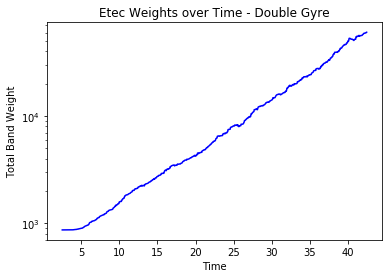

In [12]:
#Finally, let's create a graph of the stretching over time
plt.semilogy(times,Weights,"b-")
plt.ylabel("Total Band Weight")
plt.xlabel("Time")
plt.title("Etec Weights over Time - Double Gyre")
plt.show()

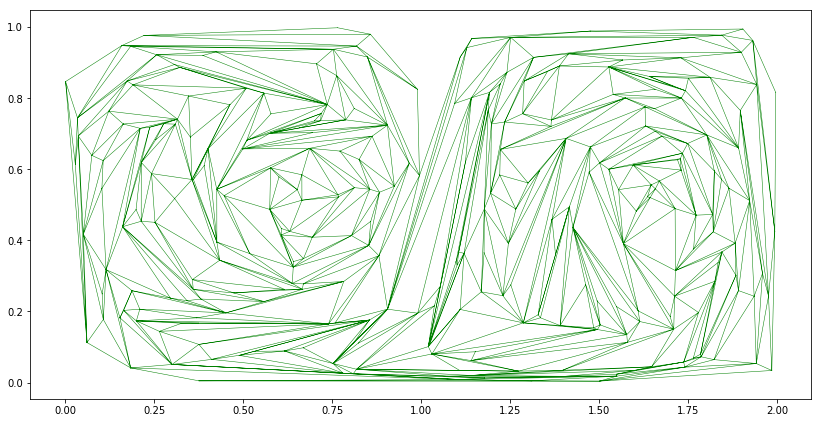

In [13]:
#And the final triangulation
tri.TriangulationPlot()